In [128]:
#importing all the required lib
import pandas as pd
import numpy as np 
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, Concatenate, MaxPool1D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, TerminateOnNaN, Callback
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from sklearn.utils import compute_class_weight
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
from IPython.display import SVG, display
import pickle 
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Input,Dense,LSTM
from tensorflow.keras.layers import Input, Embedding, Conv1D, Concatenate, MaxPool1D, Flatten, Dropout, Dense, BatchNormalization

In [129]:
import pickle 
glovevectorfile = open('glove_vectors', 'rb')
glovevector = pickle.load(glovevectorfile)

In [130]:
project_data = pd.read_csv('preprocessed_data.csv')
project_data.shape

(109248, 9)

In [131]:

project_data['remaining_input'] = project_data['teacher_number_of_previously_posted_projects'] + project_data['price']

In [132]:
# droping class label data
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data
project_data.shape

(109248, 9)

In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print('Train Data Set', X_train.shape, y_train.shape)
print('Cross Validate Data Set', X_cv.shape, y_cv.shape)
print('Test Data Set', X_test.shape, y_test.shape)

Train Data Set (69918, 9) (69918,)
Cross Validate Data Set (17480, 9) (17480,)
Test Data Set (21850, 9) (21850,)


In [134]:
print('Train Data Set', X_train.shape, y_train.shape)
print('Cross Validate Data Set', X_cv.shape, y_cv.shape)
print('Test Data Set', X_test.shape, y_test.shape)
print('*'*100)

Train Data Set (69918, 9) (69918,)
Cross Validate Data Set (17480, 9) (17480,)
Test Data Set (21850, 9) (21850,)
****************************************************************************************************


In [135]:
# build logic to tokenize input
# Steps below
# 1. Count frequencies of each word
# 2. Sort frequencies by desc order
# 3. Assign rank to frequencies
# 4. Tokenize words in the main categorical variable
sent_list = [
    'The phone is very fast',
    'The phone is not bad',
    'I have good phone',
]

# count no. of words and assign it to dictionary
words_dict = {}
for sent in sent_list:
    words = sent.split()
    for i in words:
        if(i in words_dict):
            words_dict[i] += 1
        else:
            words_dict[i] = 1
            
print(words_dict)
print('*'*100)

# sort dictionary by their frequencies
sorted_dict = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_dict)
print('*'*100)


# assign rank to each word
rank = 1
final_dict = {} 
for item in sorted_dict:
    item = list(item)
    final_dict[item[0]] = rank
    rank += 1
    
print(final_dict)
print('*'*100)

# finally convert main sentences into tokens
tokenize_list = []
for sent in sent_list:
    words = sent.split()
    tokenize_sublist = []
    for item in words:
        if(item in final_dict):
            tokenize_sublist.append(final_dict[item])
    
    tokenize_list.append(tokenize_sublist)
        
print(tokenize_list)
print('*'*100)

{'The': 2, 'phone': 3, 'is': 2, 'very': 1, 'fast': 1, 'not': 1, 'bad': 1, 'I': 1, 'have': 1, 'good': 1}
****************************************************************************************************
[('phone', 3), ('The', 2), ('is', 2), ('very', 1), ('fast', 1), ('not', 1), ('bad', 1), ('I', 1), ('have', 1), ('good', 1)]
****************************************************************************************************
{'phone': 1, 'The': 2, 'is': 3, 'very': 4, 'fast': 5, 'not': 6, 'bad': 7, 'I': 8, 'have': 9, 'good': 10}
****************************************************************************************************
[[2, 1, 3, 4, 5], [2, 1, 3, 6, 7], [8, 9, 10, 1]]
****************************************************************************************************


In [136]:
def fit_transform_train_data(train_data):
    bag_of_words = CountVectorizer(lowercase= False)
    bow_words = bag_of_words.fit_transform(train_data)
    
    # Store calculated frequencies in the dictionaries
    freqs = bow_words.sum(axis=0).A1
    index = freqs.argsort()
    words = bag_of_words.get_feature_names_out()
    #print(freqs, index, words)
    
    rank_dict = {}
    rank = 1
    for item in index[::-1]:
        feature_name = words[item]
        rank_dict[feature_name] = rank
        rank += 1
    return [words, rank_dict]


def transform_data(data, rank_dict):
    # finally convert main sentences into tokens
    tokenize_list = []
    for sent in data:
        words = sent.split()
        tokenize_sublist = []
        for item in words:
            if(item in rank_dict):
                tokenize_sublist.append(rank_dict[item])

        tokenize_list.append(tokenize_sublist)
        
        
    return tokenize_list

In [137]:
# Test above implementation
features, rank_dict = fit_transform_train_data(project_data['school_state'])
print(features, rank_dict)
tokenize_data = transform_data(project_data['school_state'], rank_dict)
print(project_data['school_state'][0])
print(tokenize_data[0])
print(project_data['school_state'][10])
print(tokenize_data[10])
print(len(features))

['ak' 'al' 'ar' 'az' 'ca' 'co' 'ct' 'dc' 'de' 'fl' 'ga' 'hi' 'ia' 'id'
 'il' 'in' 'ks' 'ky' 'la' 'ma' 'md' 'me' 'mi' 'mn' 'mo' 'ms' 'mt' 'nc'
 'nd' 'ne' 'nh' 'nj' 'nm' 'nv' 'ny' 'oh' 'ok' 'or' 'pa' 'ri' 'sc' 'sd'
 'tn' 'tx' 'ut' 'va' 'vt' 'wa' 'wi' 'wv' 'wy'] {'ca': 1, 'tx': 2, 'ny': 3, 'fl': 4, 'nc': 5, 'il': 6, 'ga': 7, 'sc': 8, 'mi': 9, 'pa': 10, 'in': 11, 'mo': 12, 'oh': 13, 'la': 14, 'ma': 15, 'wa': 16, 'ok': 17, 'nj': 18, 'az': 19, 'va': 20, 'wi': 21, 'al': 22, 'ut': 23, 'tn': 24, 'ct': 25, 'md': 26, 'nv': 27, 'ms': 28, 'ky': 29, 'or': 30, 'mn': 31, 'co': 32, 'ar': 33, 'id': 34, 'ia': 35, 'ks': 36, 'nm': 37, 'dc': 38, 'hi': 39, 'me': 40, 'wv': 41, 'nh': 42, 'ak': 43, 'de': 44, 'ne': 45, 'sd': 46, 'ri': 47, 'mt': 48, 'nd': 49, 'wy': 50, 'vt': 51}
ca
[1]
il
[6]
51


In [138]:
# One hot encoding of Categorical Feature
# - school_state : categorical data
(school_state_features, rank_dict) = fit_transform_train_data(X_train['school_state'].values)# Fit has to happen only on train data

X_train_school_state_ohe = transform_data(X_train['school_state'].values, rank_dict)
X_cv_school_state_ohe = transform_data(X_cv['school_state'].values, rank_dict)
X_test_school_state_ohe = transform_data(X_test['school_state'].values, rank_dict)

print(len(X_train_school_state_ohe), y_train.shape)
print(len(X_cv_school_state_ohe), y_cv.shape)
print(len(X_test_school_state_ohe), y_test.shape)
print(school_state_features)
print(len(school_state_features))
print('*'*100)

69918 (69918,)
17480 (17480,)
21850 (21850,)
['ak' 'al' 'ar' 'az' 'ca' 'co' 'ct' 'dc' 'de' 'fl' 'ga' 'hi' 'ia' 'id'
 'il' 'in' 'ks' 'ky' 'la' 'ma' 'md' 'me' 'mi' 'mn' 'mo' 'ms' 'mt' 'nc'
 'nd' 'ne' 'nh' 'nj' 'nm' 'nv' 'ny' 'oh' 'ok' 'or' 'pa' 'ri' 'sc' 'sd'
 'tn' 'tx' 'ut' 'va' 'vt' 'wa' 'wi' 'wv' 'wy']
51
****************************************************************************************************


In [139]:
# print(X_train['project_grade_category'])
# One hot encoding of Categorical Feature
# - project_grade_category : categorical data
# Convert one hot encoding for project grade category
(project_grade_category_features, rank_dict) =  fit_transform_train_data(X_train['project_grade_category'].values)# Fit has to happen only on train data

X_train_project_grade_category_ohe = transform_data(X_train['project_grade_category'].values, rank_dict)
X_cv_project_grade_category_ohe = transform_data(X_cv['project_grade_category'].values, rank_dict)
X_test_project_grade_category_ohe = transform_data(X_test['project_grade_category'].values, rank_dict)

print(len(X_train_project_grade_category_ohe), y_train.shape)
print(len(X_cv_project_grade_category_ohe), y_cv.shape)
print(len(X_test_project_grade_category_ohe), y_test.shape)
# print(project_grade_category_features)
print(len(project_grade_category_features))
print('*'*100)

69918 (69918,)
17480 (17480,)
21850 (21850,)
4
****************************************************************************************************


In [140]:
# One hot encoding of Categorical Feature
# - clean_categories : categorical data
# print(X_train['clean_categories'].describe())
(clean_categories_features, rank_dict) =  fit_transform_train_data(X_train['clean_categories'].values)# Fit has to happen only on train data

# print(rank_dict)

X_train_clean_categories_ohe = transform_data(X_train['clean_categories'].values, rank_dict)
X_cv_clean_categories_ohe = transform_data(X_cv['clean_categories'].values, rank_dict)
X_test_clean_categories_ohe = transform_data(X_test['clean_categories'].values, rank_dict)

print(len(X_train_clean_categories_ohe), y_train.shape)
print(len(X_cv_clean_categories_ohe), y_cv.shape)
print(len(X_test_clean_categories_ohe), y_test.shape)
print(clean_categories_features)
print(len(clean_categories_features))
print('*'*100)

69918 (69918,)
17480 (17480,)
21850 (21850,)
['appliedlearning' 'care_hunger' 'health_sports' 'history_civics'
 'literacy_language' 'math_science' 'music_arts' 'specialneeds' 'warmth']
9
****************************************************************************************************


In [141]:
# One hot encoding of Categorical Feature
# - clean_subcategories : categorical data
(clean_subcategories_features, rank_dict) =  fit_transform_train_data(X_train['clean_subcategories'].values)# Fit has to happen only on train data

X_train_clean_subcategories_ohe = transform_data(X_train['clean_subcategories'].values, rank_dict)
X_cv_clean_subcategories_ohe = transform_data(X_cv['clean_subcategories'].values, rank_dict)
X_test_clean_subcategories_ohe = transform_data(X_test['clean_subcategories'].values, rank_dict)

print(len(X_train_clean_subcategories_ohe), y_train.shape)
print(len(X_cv_clean_subcategories_ohe), y_cv.shape)
print(len(X_test_clean_subcategories_ohe), y_test.shape)
print(clean_subcategories_features)
print(len(clean_subcategories_features))
print('*'*100)

69918 (69918,)
17480 (17480,)
21850 (21850,)
['appliedsciences' 'care_hunger' 'charactereducation' 'civics_government'
 'college_careerprep' 'communityservice' 'earlydevelopment' 'economics'
 'environmentalscience' 'esl' 'extracurricular' 'financialliteracy'
 'foreignlanguages' 'gym_fitness' 'health_lifescience' 'health_wellness'
 'history_geography' 'literacy' 'literature_writing' 'mathematics' 'music'
 'nutritioneducation' 'other' 'parentinvolvement' 'performingarts'
 'socialsciences' 'specialneeds' 'teamsports' 'visualarts' 'warmth']
30
****************************************************************************************************


In [142]:
# One hot encoding of Categorical Feature
# - teacher_prefix : categorical data
# print(X_train['teacher_prefix'])
(teacher_prefix_features, rank_dict) =  fit_transform_train_data(X_train['teacher_prefix'].values)# Fit has to happen only on train data

X_train_teacher_prefix_ohe = transform_data(X_train['teacher_prefix'].values, rank_dict)
X_cv_teacher_prefix_ohe = transform_data(X_cv['teacher_prefix'].values, rank_dict)
X_test_teacher_prefix_ohe = transform_data(X_test['teacher_prefix'].values, rank_dict)

print(len(X_train_teacher_prefix_ohe), y_train.shape)
print(len(X_cv_teacher_prefix_ohe), y_cv.shape)
print(len(X_test_teacher_prefix_ohe), y_test.shape)
print(teacher_prefix_features)
print(len(teacher_prefix_features))
print('*'*100)

69918 (69918,)
17480 (17480,)
21850 (21850,)
['dr' 'mr' 'mrs' 'ms' 'teacher']
5
****************************************************************************************************


In [143]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def padded(encoded_docs):  
    max_length = 250
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs

In [144]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(X_train['essay'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train['essay'])
X_train_essay = padded(encoded_docs)

In [145]:
#t = Tokenizer()
#t.fit_on_texts(x_cross.cleaned_essay)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_cv['essay'])
X_cv_essay = padded(encoded_docs)

In [146]:
#t = Tokenizer()
#t.fit_on_texts(x_test.cleaned_essay)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_test['essay'])
X_test_essay = padded(encoded_docs)

In [147]:
with open(r"glove_vectors", "rb") as f:
    glove = pickle.load(f)
    glove_words = set(glove.keys())
    
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    if word in glove_words:
        embedding_vector = glove[word]
        embedding_matrix[i] = embedding_vector

In [148]:
print("embedding matrix shape",embedding_matrix.shape)

embedding matrix shape (47605, 300)


In [149]:
class_weight = compute_class_weight("balanced", classes= np.unique(y),y=y)

In [150]:
max_length_categorical_variable = 1

In [151]:
X_train_school_state_ohe = pad_sequences(X_train_school_state_ohe, maxlen=max_length_categorical_variable)
X_cv_school_state_ohe = pad_sequences(X_cv_school_state_ohe, maxlen=max_length_categorical_variable)
X_test_school_state_ohe = pad_sequences(X_test_school_state_ohe, maxlen=max_length_categorical_variable)
print(X_train_school_state_ohe.shape)
print(X_train_school_state_ohe[0])
print(X_train_school_state_ohe[1])
print(X_cv_school_state_ohe.shape)
print(X_cv_school_state_ohe[0])
print(X_test_school_state_ohe.shape)
print(X_test_school_state_ohe[0])

(69918, 1)
[1]
[1]
(17480, 1)
[12]
(21850, 1)
[7]


In [152]:
X_train_project_grade_category_ohe = pad_sequences(X_train_project_grade_category_ohe, maxlen=max_length_categorical_variable)
X_cv_project_grade_category_ohe = pad_sequences(X_cv_project_grade_category_ohe, maxlen=max_length_categorical_variable)
X_test_project_grade_category_ohe = pad_sequences(X_test_project_grade_category_ohe, maxlen=max_length_categorical_variable)
print(X_train_project_grade_category_ohe.shape)
print(X_train_project_grade_category_ohe[0])
print(X_train_project_grade_category_ohe[1])
print(X_cv_project_grade_category_ohe.shape)
print(X_cv_project_grade_category_ohe[0])
print(X_test_school_state_ohe.shape)
print(X_test_school_state_ohe[0])

(69918, 1)
[2]
[1]
(17480, 1)
[2]
(21850, 1)
[7]


In [153]:
X_train_clean_categories_ohe = pad_sequences(X_train_clean_categories_ohe, maxlen=max_length_categorical_variable)
X_cv_clean_categories_ohe = pad_sequences(X_cv_clean_categories_ohe, maxlen=max_length_categorical_variable)
X_test_clean_categories_ohe = pad_sequences(X_test_clean_categories_ohe, maxlen=max_length_categorical_variable)
print(X_train_clean_categories_ohe.shape)
print(X_train_clean_categories_ohe[0])
print(X_train_clean_categories_ohe[1])
print(X_cv_clean_categories_ohe.shape)
print(X_cv_clean_categories_ohe[0])
print(X_test_clean_categories_ohe.shape)
print(X_test_clean_categories_ohe[0])

(69918, 1)
[9]
[2]
(17480, 1)
[6]
(21850, 1)
[4]


In [154]:
X_train_clean_subcategories_ohe = pad_sequences(X_train_clean_subcategories_ohe, maxlen=max_length_categorical_variable)
X_cv_clean_subcategories_ohe = pad_sequences(X_cv_clean_subcategories_ohe, maxlen=max_length_categorical_variable)
X_test_clean_subcategories_ohe = pad_sequences(X_test_clean_subcategories_ohe, maxlen=max_length_categorical_variable)
print(X_train_clean_subcategories_ohe.shape)
print(X_train_clean_subcategories_ohe[0])
print(X_train_clean_subcategories_ohe[1])
print(X_cv_clean_subcategories_ohe.shape)
print(X_cv_clean_subcategories_ohe[0])
print(X_test_clean_subcategories_ohe.shape)
print(X_test_clean_subcategories_ohe[0])

(69918, 1)
[21]
[2]
(17480, 1)
[7]
(21850, 1)
[4]


In [155]:
X_train_teacher_prefix_ohe = pad_sequences(X_train_teacher_prefix_ohe, maxlen=max_length_categorical_variable)
X_cv_teacher_prefix_ohe = pad_sequences(X_cv_teacher_prefix_ohe, maxlen=max_length_categorical_variable)
X_test_teacher_prefix_ohe = pad_sequences(X_test_teacher_prefix_ohe, maxlen=max_length_categorical_variable)
print(X_train_teacher_prefix_ohe.shape)
print(X_train_teacher_prefix_ohe[0])
print(X_train_teacher_prefix_ohe[1])
print(X_cv_teacher_prefix_ohe.shape)
print(X_cv_teacher_prefix_ohe[0])
print(X_test_teacher_prefix_ohe.shape)
print(X_test_teacher_prefix_ohe[0])

(69918, 1)
[2]
[1]
(17480, 1)
[2]
(21850, 1)
[4]


In [156]:
#AUC score
def auc( y_true, y_pred ) :
    try:
        score = tf.numpy_function( lambda y_true, y_pred : roc_auc_score( y_true, y_pred, average='macro', sample_weight=None).astype('float32'),
                        [y_true, y_pred],
                        'float32',
                        name='sklearnAUC' )
    except ValueError:
        pass
    return score

In [157]:
def get_categorical(y_train, number_of_unique_classes):
    Y_train = []
    #print("type y_train:", type(y_train))
    for class_ in y_train:
        class__ = tf.keras.utils.to_categorical(class_, number_of_unique_classes) 
        Y_train.append(class__)
    Y_train = np.array(Y_train)
    return Y_train

y_train = get_categorical(y_train, 2)
y_train[0:5]
y_cv = get_categorical(y_cv, 2)
y_cv[0:5]
y_test = get_categorical(y_test, 2)
y_test[0:5]
#Y = get_categorical(y, 2)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [158]:
X_train_essay_mat = embedding_matrix

In [160]:
from tensorflow.keras.layers import LeakyReLU
import datetime

# Create model 1

#input 1 essay text
input1 = Input(shape=(250,))
# x1 = Embedding(input_dim=49042,output_dim= 300)(input1)
x1 = Embedding(input_dim=47605,output_dim= 300,weights=[X_train_essay_mat],trainable=False)(input1)
x1 = tf.keras.layers.SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
# x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)  

# input 2 school_state 51
input2 = Input(shape=(1,))
x2 = Embedding(input_dim=cat_sizes['school_state']+1, output_dim=cat_embsizes['school_state'])(input2)#input_dim=52
x2 = Flatten()(x2)

# input 3 project_grade_cat 4
input3 = Input(shape=(1,))
x3 = Embedding(input_dim=cat_sizes['project_grade_category']+1, output_dim=cat_embsizes['project_grade_category'])(input3)
x3 = Flatten()(x3)

# input 4 clean_categories 9
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=cat_sizes['clean_categories']+1, output_dim=cat_embsizes['clean_categories'])(input4)
x4 = Flatten()(x4)

# input 5 clean_subcategories 30
input5 = Input(shape=(1,))
x5 = Embedding(input_dim=cat_sizes['clean_subcategories']+1, output_dim=cat_embsizes['clean_subcategories'])(input5)
x5 = Flatten()(x5)

# input 6 teacher_prefix 5
input6 = Input(shape=(1,))
x6 = Embedding(input_dim=cat_sizes['teacher_prefix']+1, output_dim=cat_embsizes['teacher_prefix'])(input6)
x6 = Flatten()(x6)

# print(cat_concat)

#input 7 remaining inout
input7 = Input(shape=(1,))
x7 = Dense(16,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
x7 = LeakyReLU()(x7)

concat = tf.keras.layers.concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = LeakyReLU()(x)
x = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)#
model.run_eagerly = True
log_dir = "logs/model1" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1, write_graph = True)
tensorboard = TensorBoard(log_dir='/content/drive/My Drive/LSTM Output/logs/{}'.format(time()))
# tensorboard = TensorBoard(log_dir='logs')
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=[auc])
print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_46 (Embedding)        (None, 250, 300)     14281500    input_56[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_10 (SpatialDr (None, 250, 300)     0           embedding_46[0][0]               
__________________________________________________________________________________________________
input_57 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [161]:
tf.keras.utils.plot_model(model, show_shapes = True, to_file = "model1.png")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [162]:
# print shape of train data
print(X_train_essay.shape)
print(X_train_school_state_ohe.shape)
print(X_train_project_grade_category_ohe.shape)
print(X_train_clean_categories_ohe.shape)
print(X_train_clean_subcategories_ohe.shape)
print(X_train_teacher_prefix_ohe.shape)
print(X_train['remaining_input'].shape)
print('*'*100)
# print shape of cv data
print(X_cv_essay.shape)
print(X_cv_school_state_ohe.shape)
print(X_cv_project_grade_category_ohe.shape)
print(X_cv_clean_categories_ohe.shape)
print(X_cv_clean_subcategories_ohe.shape)
print(X_cv_teacher_prefix_ohe.shape)
print(X_cv['remaining_input'].shape)
print('*'*100)
# print shape of test data
print(X_test_essay.shape)
print(X_test_school_state_ohe.shape)
print(X_test_project_grade_category_ohe.shape)
print(X_test_clean_categories_ohe.shape)
print(X_test_clean_subcategories_ohe.shape)
print(X_test_teacher_prefix_ohe.shape)
print(X_test['remaining_input'].shape)
print('*'*100)

(69918, 250)
(69918, 1)
(69918, 1)
(69918, 1)
(69918, 1)
(69918, 1)
(69918,)
****************************************************************************************************
(17480, 250)
(17480, 1)
(17480, 1)
(17480, 1)
(17480, 1)
(17480, 1)
(17480,)
****************************************************************************************************
(21850, 250)
(21850, 1)
(21850, 1)
(21850, 1)
(21850, 1)
(21850, 1)
(21850,)
****************************************************************************************************


In [ ]:
# with open('/content/drive/My Drive/LSTM Output/abc.gdoc', 'w') as f:
#   f.write('content')

#model fitting
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="weights_copy_new_23_1.best.hdf5"

earlystopping_1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint,tensorboard,earlystopping_1]

model.fit([X_train_essay, X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_teacher_prefix_ohe, X_train['remaining_input']], y_train, epochs=50, verbose=1, batch_size=256, validation_data=([X_cv_essay, X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv['remaining_input']]  , y_cv), callbacks = callbacks_list)

Train on 69918 samples, validate on 17480 samples
Epoch 1/50
59904/69918 [========================>.....] - ETA: 28s - loss: 0.4932 - auc: 0.5843

In [42]:
# Load model with best weights

#input 1 essay text
input1 = Input(shape=(250,))
# x1 = Embedding(input_dim=49042,output_dim= 300)(input1)
x1 = Embedding(input_dim=47439,output_dim= 300,weights=[X_train_essay_mat],trainable=False)(input1)
x1 = tf.keras.layers.SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
# x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)  

# input 2 school_state 51
input2 = Input(shape=(1,))
x2 = Embedding(input_dim=cat_sizes['school_state']+1, output_dim=cat_embsizes['school_state'])(input2)#input_dim=52
x2 = Flatten()(x2)

# input 3 project_grade_cat 4
input3 = Input(shape=(1,))
x3 = Embedding(input_dim=cat_sizes['project_grade_category']+1, output_dim=cat_embsizes['project_grade_category'])(input3)
x3 = Flatten()(x3)

# input 4 clean_categories 9
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=cat_sizes['clean_categories']+1, output_dim=cat_embsizes['clean_categories'])(input4)
x4 = Flatten()(x4)

# input 5 clean_subcategories 30
input5 = Input(shape=(1,))
x5 = Embedding(input_dim=cat_sizes['clean_subcategories']+1, output_dim=cat_embsizes['clean_subcategories'])(input5)
x5 = Flatten()(x5)

# input 6 teacher_prefix 5
input6 = Input(shape=(1,))
x6 = Embedding(input_dim=cat_sizes['teacher_prefix']+1, output_dim=cat_embsizes['teacher_prefix'])(input6)
x6 = Flatten()(x6)

# print(cat_concat)

#input 7 remaining inout
input7 = Input(shape=(1,))
x7 = Dense(16,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
x7 = LeakyReLU()(x7)

concat = tf.keras.layers.concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = LeakyReLU()(x)
x = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)#
model.run_eagerly = True
log_dir = "logs/model1" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1, write_graph = True)
#tensorboard = TensorBoard(log_dir='/content/drive/My Drive/LSTM Output/logs/{}'.format(time()))
# tensorboard = TensorBoard(log_dir='logs')
model.load_weights(filepath)#"weights_copy.best.hdf5"
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=['accuracy', auc])
print(model.summary())
# print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 250, 300)     14231700    input_10[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 250, 300)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [43]:
print("AUC for test data: %0.3f"%roc_auc_score(y_test,model.predict([X_test_essay, X_test_school_state_ohe, X_test_project_grade_category_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_teacher_prefix_ohe, X_test['remaining_input']])))
print("AUC for CV data: %0.3f"%roc_auc_score(y_cv,model.predict([X_cv_essay, X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv['remaining_input']])))
print("AUC for train data: %0.3f"%roc_auc_score(y_train,model.predict([X_train_essay, X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_teacher_prefix_ohe, X_train['remaining_input']])))

AUC for test data: 0.764
AUC for CV data: 0.759
AUC for train data: 0.781


In [44]:
vectorizer = TfidfVectorizer(min_df=10,max_features=10000) #Defining TFIDF with min_df=10
imp_tf = vectorizer.fit(X_train['essay'])

In [45]:
idf_values = vectorizer.idf_ 

In [46]:
df = pd.DataFrame(idf_values, columns= ["idf"])
df.head()

,idf
0,7.272291
1,5.908986
2,4.470309
3,3.808925
4,7.164660


<AxesSubplot:ylabel='idf'>

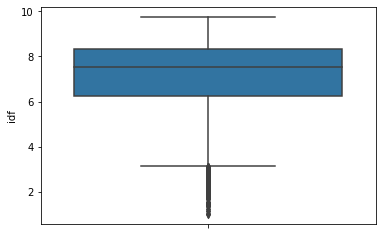

In [47]:
import seaborn as sns

sns.boxplot(y = "idf", data = df )

In [48]:
#calculating speed values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var =idf_values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 1.007926179083547
10 percentile value is 4.959905387988936
20 percentile value is 5.876571284001801
30 percentile value is 6.5905723008449515
40 percentile value is 7.111667591248398
50 percentile value is 7.549922522179553
60 percentile value is 7.89241283112633
70 percentile value is 8.203848989586218
80 percentile value is 8.491531062038
90 percentile value is 8.75389532650549
100 percentile value is  9.757197435369275


In [49]:
for i in range(0,100,5):
    var =idf_values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 1.007926179083547
5 percentile value is 4.107263350709804
10 percentile value is 4.959905387988936
15 percentile value is 5.459293791109153
20 percentile value is 5.876571284001801
25 percentile value is 6.260689873902795
30 percentile value is 6.5905723008449515
35 percentile value is 6.861787883443153
40 percentile value is 7.111667591248398
45 percentile value is 7.342908352795227
50 percentile value is 7.549922522179553
55 percentile value is 7.724275909324332
60 percentile value is 7.89241283112633
65 percentile value is 8.044218843994333
70 percentile value is 8.203848989586218
75 percentile value is 8.348430218397326
80 percentile value is 8.491531062038
85 percentile value is 8.628732183551485
90 percentile value is 8.75389532650549
95 percentile value is 8.896996170146164
100 percentile value is  9.757197435369275


In [50]:
print("The 25 percentile of idf score is :", np.percentile(idf_values,[25]))
print("The 75 percentile of idf score is :",np.percentile(idf_values,[75]))

The 25 percentile of idf score is : [6.26068987]
The 75 percentile of idf score is : [8.34843022]


In [51]:
percentile_25th = 2#np.percentile(idf_values,[25])
percentile_75th = 10#np.percentile(idf_values,[75])

In [52]:
feature_idf = zip(imp_tf.get_feature_names(),idf_values)

feature_name = []
for x,y in feature_idf:
    
    if y >= percentile_25th and y <= percentile_75th:
        feature_name.append(x)

print(len(feature_name))

9975


In [53]:
print(feature_name)

['00', '000', '10', '100', '1000', '100th', '101', '10th', '11', '110', '1100', '115', '11th', '12', '120', '1200', '125', '12th', '13', '130', '14', '140', '1400', '15', '150', '1500', '16', '160', '1600', '17', '170', '18', '180', '19', '1st', '20', '200', '2000', '2003', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '20th', '21', '21st', '22', '23', '24', '25', '250', '26', '27', '28', '280', '29', '2d', '2nd', '30', '300', '3000', '31', '32', '320', '33', '34', '35', '350', '36', '360', '365', '37', '38', '39', '3d', '3doodler', '3doodlers', '3rd', '40', '400', '41', '42', '43', '44', '45', '450', '46', '47', '48', '49', '4k', '4th', '50', '500', '504', '51', '52', '53', '54', '55', '550', '56', '560', '57', '58', '5k', '5th', '60', '600', '61', '62', '63', '64', '65', '650', '66', '67', '68', '69', '693', '6th', '70', '700', '71', '72', '73', '74', '75', '750', '76', '77', '78', '79', '7th', '80', '800', '81', '82', '83', '84', '85', '850'

In [63]:
from tqdm import tqdm
def get_text_on_idf_features(essay_text):
    '''This method collects words within 25 to 75 percentile'''
    preprocessed_text = []
    # Iterate each essay text
    for sent in tqdm(essay_text):
        words = sent.split()
        final_sent = ''
        # Iterate for each esssay word
        for word in words:
          # Check word exists in idf corpus
          if(word in feature_name):
            final_sent += ' ' + word
        preprocessed_text.append(final_sent)
    return preprocessed_text 

In [64]:
# sample 1
sample_data = get_text_on_idf_features(['I am here', 'I am here', 'I am here', 'I am here'])
sample_data

100%|██████████| 4/4 [00:00<00:00, 1084.43it/s]


[' am here', ' am here', ' am here', ' am here']

In [65]:
print(X_train['essay'].shape)
print(type(X_train['essay']))
print(X_train['essay'][0:5])
print(X_train['essay'][0:1])

(69918,)
<class 'pandas.core.series.Series'>
89428     at home students may face sorts challenges com...
107461    nearly 80 students nvms receive free reduced p...
54172     i passionate inner city physical education tea...
62870     i love i care i want best that students hear d...
62940     i privilege working great group 6th grade stud...
Name: essay, dtype: object
89428    at home students may face sorts challenges com...
Name: essay, dtype: object


In [66]:
# sample 2
sample_data_2 = get_text_on_idf_features(X_train['essay'][0:500])
print(sample_data_2)

100%|██████████| 500/500 [00:09<00:00, 50.52it/s]

[' at home may face sorts challenges living low income high poverty neighborhood in however energetic fun loving five year olds eager get excited discovering something new curious loves explore play touch if walk given find us moving around controlled chaos laugh talk sing outside having access technology enhances every student it allows concepts presented variety ways increases student success with budgetary limitations home opportunities using 21st century tools ipads bring life whole group well get extra practice small group teaching stations ipad document camera interact projected image foster engagement increase types teaching methods using ipads small groups well centers tablets skills subject areas', ' nearly 80 receive free reduced price lunch yet extremely motivated outstanding education experience here extremely diverse group teach diverse group large public middle indiana extremely proud excited new year know everything successful accomplish much given unable get additional 

In [67]:
# sample 3 final testing
sample_data_3 = get_text_on_idf_features(['piano specially paramount microscopes figuring'])
sample_data_3

100%|██████████| 1/1 [00:00<00:00, 921.83it/s]


[' piano specially paramount microscopes figuring']

In [68]:
print(X_train['essay'][0:10])

89428     at home students may face sorts challenges com...
107461    nearly 80 students nvms receive free reduced p...
54172     i passionate inner city physical education tea...
62870     i love i care i want best that students hear d...
62940     i privilege working great group 6th grade stud...
87664     i 5th grade science teacher trinity gardens ro...
45317     my students come different kinds backgrounds m...
55114     my classroom made 18 students diverse backgrou...
101490    with academics tradition cornerstones foundati...
67918     my day first grade consists hard working stude...
Name: essay, dtype: object


In [69]:
# filter train data
X_train_essay_orig = X_train['essay']
X_train_assign_2 = []
X_train_assign_2 = get_text_on_idf_features(X_train['essay'])
len(X_train_assign_2)

100%|██████████| 69918/69918 [23:01<00:00, 50.60it/s]


69918

In [70]:
# filter cv data
X_cv_essay_orig = X_cv['essay']
X_cv_assign_2 = []
X_cv_assign_2 = get_text_on_idf_features(X_cv['essay'])
len(X_cv_assign_2)

100%|██████████| 17480/17480 [06:17<00:00, 46.31it/s]


17480

In [71]:
# filter test data
X_test_essay_orig = X_test['essay']
X_test_assign_2 = []
X_test_assign_2 = get_text_on_idf_features(X_test['essay'])
len(X_test_assign_2)

100%|██████████| 21850/21850 [08:18<00:00, 43.85it/s]


21850

In [72]:
print(X_train['essay'])
print(X_cv['essay'])
print(X_test['essay'])
print(X_train_essay_orig)
print(X_cv_essay_orig)
print(X_test_essay_orig)

89428     at home students may face sorts challenges com...
107461    nearly 80 students nvms receive free reduced p...
54172     i passionate inner city physical education tea...
62870     i love i care i want best that students hear d...
62940     i privilege working great group 6th grade stud...
                                ...                        
37324     my students attend small neighborhood school h...
79617     i teach title l school michigan many students ...
77244     my students not students children they come va...
98555     my students eager learn experience music day w...
24076     my students amazing they knowledgable helps le...
Name: essay, Length: 69918, dtype: object
80664     this year i working charter school inner city ...
4343      my students unbelievable people i not even con...
53126     my students dark brown eyes glisten light they...
102875    my class smart bunch kids love learn i work hi...
2627      our classroom loving family we spend lot time ..

In [73]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(X_train_assign_2)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train_assign_2)
X_train_essay = padded(encoded_docs)

In [74]:
#t = Tokenizer()
#t.fit_on_texts(x_cross.cleaned_essay)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_cv_assign_2)
X_cv_essay = padded(encoded_docs)

In [75]:
#t = Tokenizer()
#t.fit_on_texts(x_test.cleaned_essay)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_test_assign_2)
X_test_essay = padded(encoded_docs)

In [76]:
embeddings_index = dict()
f = open('glove.6B.300d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [77]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [78]:
print(X_train['essay'][0:5].values[0])
string = str(X_train['essay'][0:5].values[0])
type(string)

at home students may face sorts challenges come living low income high poverty neighborhood in classroom however energetic fun loving five year olds my students eager learn get excited discovering something new we curious class loves explore learn play touch if walk class given day find us moving around controlled chaos we love laugh talk sing learn outside having access technology enhances learning every student it allows concepts presented variety ways increases student success with budgetary limitations home school students not many opportunities learn using 21st century tools we use ipads bring life whole group learning well get extra practice small group teaching stations i also use ipad document camera students able interact projected image this help foster engagement increase types teaching methods i able use we using ipads small groups well centers students able use tablets work skills subject areas nannan


str

In [79]:
print("embedding matrix shape",embedding_matrix.shape)

embedding matrix shape (9976, 300)


In [80]:
X_train_essay_mat = embedding_matrix
X_train_essay_mat.shape

(9976, 300)

In [82]:
# Create model 1 for assignment 2

#input 1 essay text
input1 = Input(shape=(250,))
# x1 = Embedding(input_dim=49042,output_dim= 300)(input1)
x1 = Embedding(input_dim=9976,output_dim= 300,weights=[X_train_essay_mat],trainable=False)(input1)
x1 = tf.keras.layers.SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
# x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)  

# input 2 school_state 51
input2 = Input(shape=(1,))
x2 = Embedding(input_dim=cat_sizes['school_state']+1, output_dim=cat_embsizes['school_state'])(input2)#input_dim=52
x2 = Flatten()(x2)

# input 3 project_grade_cat 4
input3 = Input(shape=(1,))
x3 = Embedding(input_dim=cat_sizes['project_grade_category']+1, output_dim=cat_embsizes['project_grade_category'])(input3)
x3 = Flatten()(x3)

# input 4 clean_categories 9
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=cat_sizes['clean_categories']+1, output_dim=cat_embsizes['clean_categories'])(input4)
x4 = Flatten()(x4)

# input 5 clean_subcategories 30
input5 = Input(shape=(1,))
x5 = Embedding(input_dim=cat_sizes['clean_subcategories']+1, output_dim=cat_embsizes['clean_subcategories'])(input5)
x5 = Flatten()(x5)

# input 6 teacher_prefix 5
input6 = Input(shape=(1,))
x6 = Embedding(input_dim=cat_sizes['teacher_prefix']+1, output_dim=cat_embsizes['teacher_prefix'])(input6)
x6 = Flatten()(x6)

# print(cat_concat)

#input 7 remaining inout
input7 = Input(shape=(1,))
x7 = Dense(16,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
x7 = LeakyReLU()(x7)

concat = tf.keras.layers.concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = LeakyReLU()(x)
x = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)#
model.run_eagerly = True
tensorboard = TensorBoard(log_dir='/content/drive/My Drive/LSTM Output/logs/{}'.format(time()))
# tensorboard = TensorBoard(log_dir='logs')
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=['accuracy', auc])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 250, 300)     2992800     input_18[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 250, 300)     0           embedding_15[0][0]               
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [83]:
# with open('/content/drive/My Drive/LSTM Output/abc.gdoc', 'w') as f:
#   f.write('content')

#model fitting
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="/content/drive/My Drive/LSTM Output/weights_copy_new_23_2.best.hdf5"

earlystopping_1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint,tensorboard,earlystopping_1]

model.fit([X_train_essay, X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_teacher_prefix_ohe, X_train['remaining_input']], y_train, epochs=50, verbose=1, batch_size=256, validation_data=([X_cv_essay, X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv['remaining_input']]  , y_cv), callbacks = callbacks_list)


Train on 69918 samples, validate on 17480 samples
Epoch 1/50
69918/69918 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.8143 - auc: 0.6098
Epoch 00001: val_auc improved from -inf to 0.69275, saving model to /content/drive/My Drive/LSTM Output\weights_copy_new_23_2.best.hdf5
69918/69918 [==============================] - 204s 3ms/sample - loss: 0.4969 - accuracy: 0.8143 - auc: 0.6098 - val_loss: 0.4596 - val_accuracy: 0.8486 - val_auc: 0.6928
Epoch 2/50
69918/69918 [==============================] - ETA: 0s - loss: 0.4309 - accuracy: 0.8457 - auc: 0.6798
Epoch 00002: val_auc improved from 0.69275 to 0.71779, saving model to /content/drive/My Drive/LSTM Output\weights_copy_new_23_2.best.hdf5
69918/69918 [==============================] - 210s 3ms/sample - loss: 0.4309 - accuracy: 0.8457 - auc: 0.6798 - val_loss: 0.4509 - val_accuracy: 0.8344 - val_auc: 0.7178
Epoch 3/50
69918/69918 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.8474 - auc

In [88]:
# Load model with best weights for assignment 2

#input 1 essay text
input1 = Input(shape=(250,))
# x1 = Embedding(input_dim=49042,output_dim= 300)(input1)
x1 = Embedding(input_dim=9976,output_dim= 300,weights=[X_train_essay_mat],trainable=False)(input1)
x1 = tf.keras.layers.SpatialDropout1D(0.3)(x1)
x1 = LSTM(128,return_sequences=True)(x1)
# x1 = LSTM(128,return_sequences=True)(x1)
x1 = Flatten()(x1)

#https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9
cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)  

# input 2 school_state 51
input2 = Input(shape=(1,))
x2 = Embedding(input_dim=cat_sizes['school_state']+1, output_dim=cat_embsizes['school_state'])(input2)#input_dim=52
x2 = Flatten()(x2)

# input 3 project_grade_cat 4
input3 = Input(shape=(1,))
x3 = Embedding(input_dim=cat_sizes['project_grade_category']+1, output_dim=cat_embsizes['project_grade_category'])(input3)
x3 = Flatten()(x3)

# input 4 clean_categories 9
input4 = Input(shape=(1,))
x4 = Embedding(input_dim=cat_sizes['clean_categories']+1, output_dim=cat_embsizes['clean_categories'])(input4)
x4 = Flatten()(x4)

# input 5 clean_subcategories 30
input5 = Input(shape=(1,))
x5 = Embedding(input_dim=cat_sizes['clean_subcategories']+1, output_dim=cat_embsizes['clean_subcategories'])(input5)
x5 = Flatten()(x5)

# input 6 teacher_prefix 5
input6 = Input(shape=(1,))
x6 = Embedding(input_dim=cat_sizes['teacher_prefix']+1, output_dim=cat_embsizes['teacher_prefix'])(input6)
x6 = Flatten()(x6)

# print(cat_concat)

#input 7 remaining inout
input7 = Input(shape=(1,))
x7 = Dense(16,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(input7)
x7 = LeakyReLU()(x7)

concat = tf.keras.layers.concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.5)(x)
x = LeakyReLU()(x)
x = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)

# create model with seven inputs
model = Model([input1,input2,input3,input4,input5,input6,input7], output)#
model.run_eagerly = True
tensorboard = TensorBoard(log_dir='/content/drive/My Drive/LSTM Output/logs/{}'.format(time()))
# tensorboard = TensorBoard(log_dir='logs')
model.load_weights(filepath)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0006,decay = 1e-4),metrics=['accuracy', auc])
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_35 (Embedding)        (None, 250, 300)     2992800     input_41[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_6 (SpatialDro (None, 250, 300)     0           embedding_35[0][0]               
__________________________________________________________________________________________________
input_42 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [89]:
# process other than text data
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - school_state : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)# Fit has to happen only on train data

X_train_school_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_school_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_school_state_ohe = vectorizer.transform(X_test['school_state'].values)

school_state_features = vectorizer.get_feature_names()

print(X_train_school_state_ohe.shape, y_train.shape)
print(X_cv_school_state_ohe.shape, y_cv.shape)
print(X_test_school_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

(69918, 51) (69918, 2)
(17480, 51) (17480, 2)
(21850, 51) (21850, 2)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
****************************************************************************************************


In [90]:
# One hot encoding of Categorical Feature
# - clean_categories : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)# Fit has to happen only on train data

X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

clean_categories_features = vectorizer.get_feature_names()

print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_cv_clean_categories_ohe.shape, y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

(69918, 9) (69918, 2)
(17480, 9) (17480, 2)
(21850, 9) (21850, 2)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
****************************************************************************************************


In [91]:
# One hot encoding of Categorical Feature
# - clean_subcategories : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)# Fit has to happen only on train data

X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

clean_subcategories_features = vectorizer.get_feature_names()

print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

(69918, 30) (69918, 2)
(17480, 30) (17480, 2)
(21850, 30) (21850, 2)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
****************************************************************************************************


In [92]:
print(X_train['project_grade_category'])
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)

X_train_project_grade_category_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer.transform(X_test['project_grade_category'].values)

project_grade_category_features = vectorizer.get_feature_names()

print(X_train_project_grade_category_ohe.shape, y_train.shape)
print(X_cv_project_grade_category_ohe.shape, y_cv.shape)
print(X_test_project_grade_category_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

89428     grades_prek_2
107461       grades_6_8
54172        grades_6_8
62870     grades_prek_2
62940        grades_6_8
              ...      
37324     grades_prek_2
79617     grades_prek_2
77244        grades_6_8
98555        grades_6_8
24076        grades_3_5
Name: project_grade_category, Length: 69918, dtype: object
(69918, 4) (69918, 2)
(17480, 4) (17480, 2)
(21850, 4) (21850, 2)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
****************************************************************************************************


In [93]:
print(X_train['teacher_prefix'])
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)# Fit has to happen only on train data

X_train_teacher_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_clean_teacher_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_clean_teacher_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

teacher_prefix_features = vectorizer.get_feature_names()

print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_clean_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_clean_teacher_prefix_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print('*'*100)

89428      ms
107461     ms
54172     mrs
62870     mrs
62940      ms
         ... 
37324     mrs
79617      ms
77244      ms
98555     mrs
24076      ms
Name: teacher_prefix, Length: 69918, dtype: object
(69918, 5) (69918, 2)
(17480, 5) (17480, 2)
(21850, 5) (21850, 2)
['dr', 'mr', 'mrs', 'ms', 'teacher']
****************************************************************************************************


In [94]:

X_train_remaining_input_norm = X_train['remaining_input'].values.reshape(-1,1)
X_cv_remaining_input_norm = X_cv['remaining_input'].values.reshape(-1,1)
X_test_remaining_input_norm = X_test['remaining_input'].values.reshape(-1,1)

print("After vectorizations")
print(X_train_remaining_input_norm.shape, y_train.shape)
print(X_cv_remaining_input_norm.shape, y_cv.shape)
print(X_test_remaining_input_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(69918, 1) (69918, 2)
(17480, 1) (17480, 2)
(21850, 1) (21850, 2)


In [95]:
print('Categorical Features')
print('*'*100)
print(X_train_school_state_ohe.shape, y_train.shape)
print(X_cv_school_state_ohe.shape, y_cv.shape)
print(X_test_school_state_ohe.shape, y_test.shape)
print('*'*100)
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_cv_clean_categories_ohe.shape, y_cv.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print('*'*100)
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print('*'*100)
print(X_train_project_grade_category_ohe.shape, y_train.shape)
print(X_cv_project_grade_category_ohe.shape, y_cv.shape)
print(X_test_project_grade_category_ohe.shape, y_test.shape)
print('*'*100)
print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_clean_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_clean_teacher_prefix_ohe.shape, y_test.shape)
print('*'*100)
print('Numerical Features')
print('*'*100)
print(X_train_remaining_input_norm.shape, y_train.shape)
print(X_cv_remaining_input_norm.shape, y_cv.shape)
print(X_test_remaining_input_norm.shape, y_test.shape)

Categorical Features
****************************************************************************************************
(69918, 51) (69918, 2)
(17480, 51) (17480, 2)
(21850, 51) (21850, 2)
****************************************************************************************************
(69918, 9) (69918, 2)
(17480, 9) (17480, 2)
(21850, 9) (21850, 2)
****************************************************************************************************
(69918, 30) (69918, 2)
(17480, 30) (17480, 2)
(21850, 30) (21850, 2)
****************************************************************************************************
(69918, 4) (69918, 2)
(17480, 4) (17480, 2)
(21850, 4) (21850, 2)
****************************************************************************************************
(69918, 5) (69918, 2)
(17480, 5) (17480, 2)
(21850, 5) (21850, 2)
****************************************************************************************************
Numerical Features
******************

In [96]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
# X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
# X.shape

X_train_real = X_train
X_cv_real = X_cv
X_test_real = X_test

X_train = hstack((X_train_school_state_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_project_grade_category_ohe, X_train_teacher_prefix_ohe, X_train_remaining_input_norm)).tocsr()
X_cv = hstack((X_cv_school_state_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_project_grade_category_ohe, X_cv_clean_teacher_prefix_ohe, X_cv_remaining_input_norm)).tocsr()
X_test = hstack((X_test_school_state_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_project_grade_category_ohe, X_test_clean_teacher_prefix_ohe, X_test_remaining_input_norm)).tocsr()

print(X_train_real.shape)
print(X_cv_real.shape)
print(X_test_real.shape)
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(69918, 9)
(17480, 9)
(21850, 9)
(69918, 100)
(17480, 100)
(21850, 100)


In [97]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(X_train_essay_orig)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train_essay_orig)
X_train_essay = padded(encoded_docs)

In [98]:
#t = Tokenizer()
#t.fit_on_texts(x_cross.cleaned_essay)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_cv_essay_orig)
X_cv_essay = padded(encoded_docs)

In [99]:
#t = Tokenizer()
#t.fit_on_texts(x_test.cleaned_essay)
#vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_test_essay_orig)
X_test_essay = padded(encoded_docs)

In [100]:
print("After vectorizations")
print(len(X_train_essay), y_train.shape)
print(len(X_cv_essay), y_cv.shape)
print(len(X_test_essay), y_test.shape)
# print(easy_features)
# print(len(easy_features))
print("*"*100)

After vectorizations
69918 (69918, 2)
17480 (17480, 2)
21850 (21850, 2)
****************************************************************************************************


In [101]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [102]:
X_train_essay_mat = embedding_matrix
X_train_essay_mat.shape

(47439, 300)

In [122]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(69918, 99, 1)
(17480, 99, 1)
(21850, 99, 1)


In [120]:
X_train_new=X_train[np.newaxis:,]

In [121]:
print(X_train_new.shape)

(69918, 99, 1)


X_train = np.resize(X_train,new_shape=(69918,99,1))
X_cv = np.resize(X_cv,new_shape=(17480,99,1))
X_test = np.resize(X_test,new_shape=(21850,99,1))

In [127]:
X_train=X_test.values[:, :, np.newaxis]
X_cv=X_cv.values[:, :, np.newaxis]
X_test=X_test.values[:, :, np.newaxis]

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [108]:
# Assignment #3 model 1

# input 1
input1 = Input(batch_shape=(None,250))
x1 = Embedding(input_dim=47439,output_dim= 300,weights=[X_train_essay_mat],trainable = False)(input1)
x1 = tf.keras.layers.SpatialDropout1D(0.3)(x1)
x1 = LSTM(256,return_sequences=True)(x1)
x1 = Flatten()(x1)

# input 2
input2 = Input(shape=(99,1))
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(input2)
x2 = Conv1D(filters=64,kernel_size=3,strides=1)(x2)
x2 = Flatten()(x2)

# merging both the inputs
concat = tf.keras.layers.concatenate([x1,x2])
x = Dense(512,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
x = Dropout(0.4)(x)
x = LeakyReLU()(x)
x = Dense(256,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dense(128,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(x)
x = LeakyReLU()(x)
# x = Dropout(0.6)(x)
output = Dense(2, activation = 'softmax')(x)
 
# create model with two inputs
model = Model([input1,input2], output)
model.run_eagerly = True
tensorboard = TensorBoard(log_dir='/content/drive/My Drive/LSTM Output/logs/{}'.format(time()))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0006,decay = 1e-4), metrics=['accuracy', auc])
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, 250, 300)     14231700    input_53[0][0]                   
__________________________________________________________________________________________________
input_54 (InputLayer)           [(None, 99, 1)]      0                                            
__________________________________________________________________________________________________
spatial_dropout1d_9 (SpatialDro (None, 250, 300)     0           embedding_44[0][0]               
____________________________________________________________________________________________

In [123]:
filepath="/content/drive/My Drive/LSTM Output/weights_copy_assig_3.best.hdf5"

earlystopping_1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint,tensorboard, earlystopping_1]

model.fit([X_train_essay, X_train_school_state_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_project_grade_category_ohe, X_train_teacher_prefix_ohe, X_train_remaining_input_norm], y_train, epochs=50, verbose=1, batch_size=256, validation_data=([X_cv_essay, X_cv_school_state_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_project_grade_category_ohe, X_cv_clean_teacher_prefix_ohe, X_cv_remaining_input_norm]  , y_cv), callbacks = callbacks_list)


ValueError: Error when checking input: expected input_54 to have 3 dimensions, but got array with shape (69918, 51)

In [126]:
# with open('/content/drive/My Drive/LSTM Output/abc.gdoc', 'w') as f:
#   f.write('content')

#model fitting
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
filepath="/content/drive/My Drive/LSTM Output/weights_copy_assig_3.best.hdf5"

earlystopping_1 = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint,tensorboard, earlystopping_1]

model.fit([X_train_essay, X_train], y_train, epochs=50, verbose=1, batch_size=256, validation_data=([X_cv_essay, X_cv]  , y_cv), callbacks = callbacks_list)


Train on 69918 samples, validate on 17480 samples
Epoch 1/50


ValueError: setting an array element with a sequence.